<a href="https://colab.research.google.com/github/Ganeshshaganti/audio-to-sign-language-conversion-nlp/blob/main/Spam_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Mail Detector




In [6]:
# 1. Imports and load dataset
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import joblib



In [5]:
import pandas as pd


file_path = '/content/spam (1).csv'

# Load the spam dataset
df = pd.read_csv(file_path, encoding='latin-1')

print('Shape:', df.shape)
display(df.head())

Shape: (5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
# 3. Inspect and find text & label columns
print(df.columns.tolist())

possible_label = None
possible_text = None
for c in df.columns:
    if c.lower() in ('label','target','class'):
        possible_label = c
    if c.lower() in ('message','text','sms','v2','body'):
        possible_text = c

if possible_label is None:
    possible_label = [c for c in df.columns if df[c].nunique()<=5 and df[c].dtype==object]
    possible_label = possible_label[0] if possible_label else df.columns[0]
if possible_text is None:
    possible_text = [c for c in df.columns if df[c].dtype==object and df[c].nunique()>20]
    possible_text = possible_text[0] if possible_text else df.columns[1]

label_col = possible_label
text_col = possible_text
print('Using text column:', text_col, 'and label column:', label_col)

df = df.rename(columns={text_col: 'text', label_col: 'label'})[['text','label']]
display(df.head())

['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
Using text column: v2 and label column: v1


,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [8]:
# 4. Basic preprocessing: normalize labels and text
df['label'] = df['label'].astype(str).str.lower().str.strip()
df['label'] = df['label'].replace({'ham':'ham','spam':'spam','0':'ham','1':'spam'})
if sorted(df['label'].unique()) and len(df['label'].unique())>2:
    uniques = list(df['label'].unique())
    df['label'] = df['label'].apply(lambda x: 'spam' if x==uniques[0] else 'ham')

print('Label distribution:\n', df['label'].value_counts())

X = df['text'].fillna('')
y = df['label'].map({'ham':0,'spam':1}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train size:', len(X_train), 'Test size:', len(X_test))

Label distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64
Train size: 4457 Test size: 1115


In [9]:
# 5. TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print('TF-IDF shape:', X_train_tfidf.shape)

TF-IDF shape: (4457, 3401)


=== MultinomialNB ===
Accuracy: 0.9739910313901345
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       0.99      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[965   1]
 [ 28 121]]


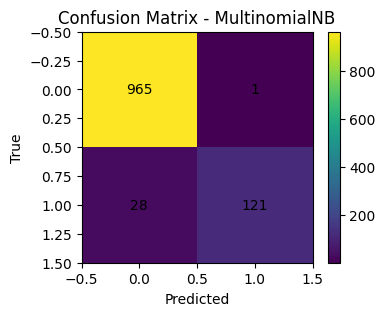

=== LogisticRegression ===
Accuracy: 0.9730941704035875
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.80      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[966   0]
 [ 30 119]]


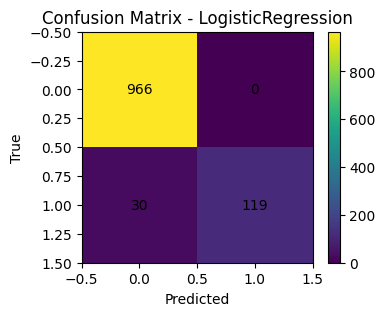

LogisticRegression ROC-AUC: 0.9847499548404129


In [10]:
# 6. Train classifiers and evaluate (MultinomialNB and LogisticRegression)
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=200)
}
results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    results[name] = {'accuracy': acc, 'preds': preds, 'model': model}
    print(f'=== {name} ===')
    print('Accuracy:', acc)
    print('Classification Report:\n', classification_report(y_test, preds, target_names=['ham','spam']))
    cm = confusion_matrix(y_test, preds)
    print('Confusion Matrix:\n', cm)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xlabel('Predicted'); plt.ylabel('True')
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, str(z), ha='center', va='center')
    plt.show()

if 'LogisticRegression' in results:
    try:
        probs = results['LogisticRegression']['model'].predict_proba(X_test_tfidf)[:,1]
        print('LogisticRegression ROC-AUC:', roc_auc_score(y_test, probs))
    except Exception as e:
        print('ROC-AUC not available:', e)

In [11]:
# 7. Save best model and vectorizer
best_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_name]['model']
print('Best model:', best_name, 'accuracy:', results[best_name]['accuracy'])

joblib.dump({'model': best_model, 'vectorizer': vectorizer}, 'spam_best_model.joblib')
print('Saved spam_best_model.joblib in current directory')

Best model: MultinomialNB accuracy: 0.9739910313901345
Saved spam_best_model.joblib in current directory
